In [25]:
import numpy as np
import numba
import copy
import matplotlib.pyplot as plt
import scipy

np.random.seed(1)

states_path = "saved states/"

# Utils

In [26]:
def initLattice(N, prob_up=0.5, prob_down=0.5):
    """Initialize lattice.

    Parameters
    ----------
    N : int
        number of sites along each dimension
    prob_up : float, optional
        probability of +1, by default 0.5
    prob_down : float, optional
        probability of -1, by default 0.5

    Returns
    -------
    np.array
        2D lattice of +1 and -1
    """
    lattice = np.random.random((N, N))

    if prob_up != 0.5:  # if prob_down is not set but prob_up is
        prob_down = 1 - prob_up
    lattice[lattice < prob_down] = -1
    lattice[lattice >= prob_down] = 1
    return lattice.astype(np.int8)


@numba.njit(nogil=True, fastmath=True)
def getNeighbors(i, j, N):
    """Get neighbors of site (i, j) on a lattice of size N.

    Parameters
    ----------
    i : int
        site index along x
    j : int
        site index along y
    N : int
        number of sites along each dimension

    Returns
    -------
    list
        array of neighbors
    """
    neighbors = np.zeros((4, 2), dtype=np.int64)
    neighbors[0] = np.array([i - 1, j])

    if i == N - 1:
        neighbors[1] = np.array([0, j])

    else:
        neighbors[1] = np.array([i + 1, j])

    neighbors[2] = np.array([i, j - 1])

    if j == N - 1:
        neighbors[3] = np.array([i, 0])

    else:
        neighbors[3] = np.array([i, j + 1])

    return neighbors


@numba.njit(nogil=True, fastmath=True)
def unique(array):
    """Get unique elements and their counts in an array.

    Parameters
    ----------
    array : np.array
        input array

    Returns
    -------
    np.array
        unique elements
    np.array
        counts of unique elements
    """
    b = np.sort(array.ravel())
    unique = list(b[:1])
    counts = [1 for _ in unique]
    for x in b[1:]:
        if x != unique[-1]:
            unique.append(x)
            counts.append(1)
        else:
            counts[-1] += 1
    return np.array(unique), np.array(counts)


@numba.njit(nogil=True, fastmath=True)
def energySite(i, j, lattice):
    """Energy of site (i, j) on lattice.

    Parameters
    ----------
    i : int
        site index along x
    j : int
        site index along y
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1

    Returns
    -------
    int
        energy of site (i, j)
    """
    Eij = 0
    N = lattice.shape[0]

    neighbors = getNeighbors(i, j, N)
    for neighbor in neighbors:
        Eij += -lattice[i, j] * lattice[neighbor[0], neighbor[1]]

    return Eij


@numba.njit(nogil=True, fastmath=True)
def totalMagnetization(lattice):
    """Total magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, nx)
        2D lattice of +1 and -1

    Returns
    -------
    int
        total magnetization
    """
    mtot = 0
    if lattice.ndim == 2:
        mtot = np.sum(lattice.flatten())

    elif lattice.ndim == 3:
        mtot = np.sum(lattice, axis=(1, 2))

    return mtot


@numba.njit(nogil=True, fastmath=True)
def totalEnergy(lattice):
    """Total energy of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, nx)
        2D lattice of +1 and -1

    Returns
    -------
    int
        total energy
    """
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            energy += energySite(i, j, lattice)

    return energy / 2


def getBinary(N):
    """Get all possible binary configurations of an NxN Ising model

    Parameters
    ----------
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of all possible binary configurations
    """
    n = N**2
    binaries = np.zeros(2**n, dtype=object)
    for i in range(2**n):
        binary = np.binary_repr(i, width=n)
        binaries[i] = binary

    return binaries


def getConfigs(N):
    """Generate all possible configurations of an NxN Ising model

    Parameters
    ----------
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of all possible configurations
    """

    n = N**2
    configs = np.zeros((2**n, n))
    for i in range(2**n):
        binary = np.binary_repr(i, width=n)
        config = np.array([int(x) for x in binary])
        configs[i] = config
    configs[configs == 0] = -1
    return configs.reshape(-1, N, N).astype(int)


def latticeToBinary(lattices):
    """Convert a set of lattices to binary

    Parameters
    ----------
    lattices : np.array, shape (nx, ny) or (nsweeps, nx, ny)
        2D or 3D array of +1 and -1

    Returns
    -------
    np.array
        binary representation of lattices
    """
    binary = (lattices + 1) // 2

    if lattices.ndim == 3:
        binary = binary.reshape(lattices.shape[0], -1)

    return binary.astype(int)


def latticeToInt(lattices):
    """Convert a set of lattices to integers

    Parameters
    ----------
    lattices : np.array, shape (nx, ny) or (nsweeps, nx, ny)
        2D or 3D array of +1 and -1

    Returns
    -------
    np.array
        integer representation of lattices
    """
    binary = latticeToBinary(lattices)
    if lattices.ndim == 3:
        nsweeps = lattices.shape[0]
        ints = np.zeros(nsweeps, dtype=np.int16)
        for i in range(nsweeps):
            ints[i] = np.int16(int("".join(binary[i].astype(str)), 2))

        return ints.astype(np.int16)

    return np.int16(int("".join(binary.astype(str)), 2))


@numba.njit
def getEnergies(lattices):
    """Get the energies of a set of lattices

    Parameters
    ----------
    lattices : np.array, shape (N, nx, ny)
        3D array of lattices

    Returns
    -------
    np.array
        array of energies
    """
    N = lattices.shape[0]
    energies = np.zeros(N, dtype=np.int64)

    for i in range(N):
        lattice = lattices[i]
        energies[i] = totalEnergy(lattice)

    return energies


def loadData(N, betas=None, maxes=None, windows=None, states_path=None, reload=False):
    try:
        if reload:
            raise Exception("force reload")

        energies_beta = np.load(
            states_path + f"energies{N}_beta.npy", allow_pickle=True
        )
        lattices_beta = np.load(
            states_path + f"lattices{N}_beta.npy", allow_pickle=True
        )
        mags_beta = np.load(states_path + f"mags{N}_beta.npy", allow_pickle=True)
        nsweeps = np.load(states_path + f"nsweeps{N}_beta.npy", allow_pickle=True)
        totalsweeps = np.load(
            states_path + f"totalsweeps{N}_beta.npy", allow_pickle=True
        )

    except Exception as e:
        print(f"failed load with exception {e}")

        if betas is None:
            betas = np.linspace(0, 1, 11)
            betas = np.append(betas, 1e100)
            nbetas = betas.shape[0]
        else:
            nbetas = betas.shape[0]

        if maxes is None:
            maxes = np.array(
                [
                    5000,
                    40000,
                    40000,
                    40000,
                    60000,
                    80000,
                    40000,
                    40000,
                    40000,
                    40000,
                    40000,
                    50000,
                ],
                dtype=np.int64,
            )
        if windows is None:
            windows = np.array(
                [
                    1000,
                    10000,
                    10000,
                    10000,
                    30000,
                    40000,
                    20000,
                    10000,
                    10000,
                    10000,
                    10000,
                    1000,
                ],
                dtype=np.int64,
            )

        lattice = initLattice(N)
        lattices_beta = [0] * nbetas
        energies_beta = [0] * nbetas
        mags_beta = [0] * nbetas
        nsweeps = np.zeros(nbetas, dtype=np.int64)
        totalsweeps = np.zeros(nbetas, dtype=np.int64)

        for i in range(nbetas):
            if i == nbetas - 1:
                lattice = initLattice(N, prob_up=1.0)
            (
                lattices_beta[i],
                energies_beta[i],
                mags_beta[i],
                nsweeps[i],
                totalsweeps[i],
            ) = simulateMetropolis(lattice, betas[i], maxes[i], windows[i])

        lattices_beta = np.array(lattices_beta, dtype=object)
        energies_beta = np.array(energies_beta, dtype=object)
        mags_beta = np.array(mags_beta, dtype=object)

        np.save(states_path + f"lattices{N}_beta.npy", lattices_beta)
        np.save(states_path + f"energies{N}_beta.npy", energies_beta)
        np.save(states_path + f"mags{N}_beta.npy", mags_beta)
        np.save(states_path + f"nsweeps{N}_beta.npy", nsweeps)
        np.save(states_path + f"totalsweeps{N}_beta.npy", totalsweeps)

    return lattices_beta, energies_beta, mags_beta, nsweeps, totalsweeps


def loadCoarseData(N, lattices=None, nsweeps=None, reload=False, states_path=None):
    try:
        if reload:
            raise Exception("force reload")

        lattices_coarse = np.load(
            states_path + f"lattices{N}_coarse.npy", allow_pickle=True
        )
        mags_coarse = np.load(states_path + f"mags{N}_coarse.npy", allow_pickle=True)

    except Exception as e:
        print(f"failed load with exception {e}")

        if lattices is None or nsweeps is None:
            raise Exception("input lattices or nsweeps not provided")

        nbetas = nsweeps.shape[0]
        bigN = lattices[0].shape[-1]
        input_lattices = np.zeros((nbetas, nsweeps.max(), bigN, bigN), dtype=np.int8)

        for i, nsweep in enumerate(nsweeps):
            input_lattices[i, :nsweep] = lattices[i]

        if N == 27:
            lattices_coarse, mags_coarse = coarse27(nbetas, nsweeps, input_lattices)

        elif N == 9:
            lattices_coarse, mags_coarse = coarse9(nbetas, nsweeps, input_lattices)

        else:
            raise Exception("coarse value not recognized")

        lattices_coarse = list(lattices_coarse)
        mags_coarse = list(mags_coarse)

        for i in range(nbetas):
            lattices_coarse[i] = lattices_coarse[i][: nsweeps[i], :, :]
            mags_coarse[i] = mags_coarse[i][: nsweeps[i]]

        lattices_coarse = np.array(lattices_coarse, dtype=object)
        mags_coarse = np.array(mags_coarse, dtype=object)

        np.save(states_path + f"lattices{N}_coarse.npy", lattices_coarse)
        np.save(states_path + f"mags{N}_coarse.npy", mags_coarse)

    return lattices_coarse, mags_coarse

# Stats

In [27]:
def theoreticalIntDistribution(beta, N):
    """Theoretical integer distribution of an NxN Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        unique integers
    np.array
        probabilities
    """
    configs = getConfigs(N)
    ints = latticeToInt(configs)
    energies = getEnergies(configs)
    uniqueEnergies, counts = np.unique(energies, return_counts=True)
    boltzmannFactors = np.exp(-beta * uniqueEnergies) * counts
    Z = np.sum(boltzmannFactors)

    energy_boltzmann_map = dict(zip(uniqueEnergies, boltzmannFactors))
    int_energy_map = dict(zip(ints, energies))
    int_probs = np.zeros(2**N**2)
    energy_degeneracy_map = dict(zip(uniqueEnergies, counts))

    for i in range(2**N**2):
        int_energy = int_energy_map[i]
        int_probs[i] = (
            energy_boltzmann_map[int_energy] / Z / energy_degeneracy_map[int_energy]
        )

    return ints, int_probs


def theoreticalEnergyDistribution(beta, N):
    """Theoretical energy distribution of an NxN Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        unique energies
    np.array
        probabilities

    Notes
    -----
    Only works for N <= 5 depending on system memory
    """
    configs = getConfigs(N)
    energies = getEnergies(configs)
    uniqueEnergies, counts = np.unique(energies, return_counts=True)
    boltzmannFactors = np.exp(-beta * uniqueEnergies) * counts
    Z = np.sum(boltzmannFactors)
    P = boltzmannFactors / Z
    return uniqueEnergies, P


@numba.njit(nogil=True, fastmath=True)
def distribution(arr):
    """Get the unique values and their probabilities of an array

    Parameters
    ----------
    arr : np.array
        input array

    Returns
    -------
    np.array
        unique values
    np.array
        probabilities
    """
    unique_vals, counts = unique(arr)
    P = counts / np.sum(counts)
    argsort = np.argsort(unique_vals)
    return unique_vals[argsort], P[argsort]


@numba.njit(nogil=True, fastmath=True)
def autoCorr(t, x, mean, var):
    """Calculate the autocorrelation of a time series

    Parameters
    ----------
    t : int
        time lag
    x : np.array
        time series
    mean : float
        mean of time series
    var : float
        variance of time series

    Returns
    -------
    float
        autocorrelation
    """
    N = len(x)
    if var == 0:  # if the variance is 0 return an infinite corr
        return -1.0
    corr = 1.0 / var * 1.0 / (N - t) * np.sum((x[0 : N - t] - mean) * (x[t:N] - mean))
    return corr


@numba.njit(nogil=True, fastmath=True)
def Stats(x):
    """Calculate the mean, variance, error, autocorrelation time kappa and tcutoff of a
    time series

    Parameters
    ----------
    x : np.array
        time series

    Returns
    -------
    float
        mean
    float
        variance
    float
        error
    float
        autocorrelation time
    int
        tcutoff
    """
    N = len(x)
    mean = np.sum(x) / (N + 0.0)
    xSquared = x * x
    var = np.sum(xSquared) / (N + 0.0) - mean * mean
    t = 0
    tempC = 0.5
    kappa = 0.0
    while tempC > 0 and t < (N - 1):
        kappa = kappa + 2.0 * tempC
        t += 1
        tempC = autoCorr(t, x, mean, var)
    if kappa == 0.0:
        kappa = 1.0
    Neff = (N + 0.0) / (kappa + 0.0)
    error = np.sqrt(var / Neff)
    return mean, var, error, kappa, t


@numba.njit(nogil=True, fastmath=True)
def magExpectation(N, mags):
    """Calculate the expected magnetization and error of a time series

    Parameters
    ----------
    N : int
        number of sites along each dimension
    mags : np.array
        time series of magnetizations

    Returns
    -------
    float
        expected magnetization
    float
        error
    int
        tcutoff
    np.array
        unique magnetizations
    np.array
        probabilities of magnetizations
    """
    mags = mags.copy()
    mags /= N**2  # magnetization per spin
    mean, var, error, kappa, tcutoff = Stats(mags)
    mags = mags[tcutoff:]
    unique_mags, p_mags = distribution(mags**2)
    expected_mag = np.sum(unique_mags * p_mags)

    return expected_mag, error, tcutoff, unique_mags, p_mags


@numba.njit(nogil=True, fastmath=True)
def energyExpectation(energies):
    """Calculate the expected energy and error of a time series

    Parameters
    ----------
    energies : np.array
        time series of energies

    Returns
    -------
    float
        expected energy
    float
        error
    int
        tcutoff
    np.array
        unique energies
    np.array
        probabilities of energies
    """
    energies = energies.copy()
    mean, var, error, kappa, tcutoff = Stats(energies)
    energies = energies[tcutoff + 1 :]
    unique_energies, p_energies = distribution(energies)
    expected_energy = np.sum(unique_energies * p_energies)

    return expected_energy, error, tcutoff, unique_energies, p_energies


def getMagExpectation(N, mags_beta):
    nbetas = mags_beta.shape[0]
    expected_mags = np.zeros(nbetas)
    error_mags = np.zeros(nbetas)
    tcutoff_mags = np.zeros(nbetas, dtype=object)
    unique_mags = np.zeros(nbetas, dtype=object)
    prob_mags = np.zeros(nbetas, dtype=object)

    for i in range(nbetas):
        exp, err, tcut, unique, p = magExpectation(N, mags_beta[i].astype(np.float64))
        expected_mags[i] = np.round(exp, 12)
        error_mags[i] = np.round(err, 12)
        tcutoff_mags[i] = np.round(tcut, 12)
        unique_mags[i] = np.round(unique, 12)
        prob_mags[i] = np.round(p, 12)

    return expected_mags, error_mags, tcutoff_mags, unique_mags, prob_mags


def getEnergyExpectation(energies_beta):
    nbetas = energies_beta.shape[0]
    expected_energies = np.zeros(nbetas)
    error_energies = np.zeros(nbetas)
    tcutoff_energies = np.zeros(nbetas, dtype=object)
    unique_energies = np.zeros(nbetas, dtype=object)
    prob_energies = np.zeros(nbetas, dtype=object)

    for i in range(nbetas):
        exp, err, tcut, unique, p = energyExpectation(
            energies_beta[i].astype(np.float64)
        )
        expected_energies[i] = np.round(exp, 12)
        error_energies[i] = np.round(err, 12)
        tcutoff_energies[i] = np.round(tcut, 12)
        unique_energies[i] = np.round(unique, 12)
        prob_energies[i] = np.round(p, 12)

    return (
        expected_energies,
        error_energies,
        tcutoff_energies,
        unique_energies,
        prob_energies,
    )

# Simulators

In [28]:
#################################### HEATBATH #########################################


def sampleSpinHeatbath(lat, i, j, betaj, rcheck):
    """sample spin for site (i, j) using heat-bath algorithm

    Parameters
    ----------
    lat : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    betaj : float
        inverse temperature in reduced units
    rcheck : float
        uniform random number for proposed move

    Returns
    -------
    int
        sampled spin
    int
        change to total magnetization
    """

    lattice = copy.deepcopy(lat)
    s0 = lattice[i, j]
    lattice[i, j] = 1
    Pup = np.exp(-betaj * energySite(i, j, lattice))
    lattice[i, j] = -1
    Pdown = np.exp(-betaj * energySite(i, j, lattice))
    T = Pup / (Pup + Pdown)
    if rcheck < T:
        s = 1
    else:
        s = -1
    dmtot = -(s0 - s)
    return s, dmtot


def simulateHeatbath(lattice, beta, nsweeps):
    """Simulate Ising model using heat-bath algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Lattices = np.zeros((nsweeps, N, N))
    for sweep in range(nsweeps):
        for i in range(N):
            for j in range(N):
                rcheck = np.random.rand()
                s, dmtot = sampleSpinHeatbath(lattice, i, j, beta, rcheck)
                lattice[i, j] = s

        Lattices[sweep] = lattice

    return Lattices


#################################### CLUSTER ##########################################


def cluster(beta, lattice, N):
    """
    Cluster algorithm for Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of sites in cluster
    """

    lattice = copy.deepcopy(lattice)
    pos = np.random.randint(0, N, 2)
    s = lattice[pos[0], pos[1]]
    allpos = np.where(lattice == s)
    allpos = np.vstack([allpos[0], allpos[1]]).T
    cluster = []
    passed = []
    cluster.append(pos)
    neighbors = []
    neighbors.extend(getNeighbors(pos[0], pos[1], N))

    while len(neighbors) > 0:
        i = neighbors[0]

        if (np.isin(i, allpos).all()) and (np.isin(i, passed).all()):
            if (1 - np.exp(-2 * beta)) > np.random.random():
                cluster.append(i)
                neighbors.extend(getNeighbors(i[0], i[1], N))

            passed.append(i)
        del neighbors[0]
    cluster = np.vstack(cluster)
    return cluster


def simulateCluster(lattice, beta, nsweeps):
    """Simulate Ising model using cluster algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """

    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Latices = np.zeros((nsweeps, N, N))

    for sweep in range(nsweeps):
        c = cluster(beta, lattice, N)
        lattice[c] *= -1

        Latices[sweep] = lattice

    return Latices


################################## METROPOLIS #########################################


@numba.njit(nogil=True, fastmath=True)
def spinFlip(lattice, i, j, beta):
    """Calculate spin flip probability and change to total magnetization.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    beta : float
        inverse temperature

    Returns
    -------
    float
        acceptance ratio
    int
        change to total magnetization due to the spin flip
    """

    dE = -2 * energySite(i, j, lattice)
    A = np.exp(-beta * dE)
    dM = -2 * lattice[i, j]
    return A, dM, dE


@numba.njit(nogil=True)
def simulateMetropolis(
    lattice, beta, maxsweeps, window=1000, energy_thresh=3, mag_thresh=0.01
):
    """Simulate Ising model using Metropolis algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps
    window : int, optional
        window size for error calculation, by default 1000

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = lattice.copy()
    N = lattice.shape[0]
    lattices = np.zeros((window, N, N), dtype=np.int8)  # moving window of last
    # sweeps
    energies = np.zeros(window, dtype=np.float64)
    mags = np.zeros(window, dtype=np.int64)
    lattices[0] = lattice
    energies[0] = totalEnergy(lattice)
    mags[0] = totalMagnetization(lattice)
    rchecks = np.random.rand(maxsweeps * N**2)
    sweep = 0
    energy_err = 1e6
    mag_err = 1e6
    loop_idx = 0
    sweep = 1

    while (energy_err > energy_thresh or mag_err > mag_thresh) and (sweep < maxsweeps):
        dE_sweep = 0
        dM_sweep = 0
        for i in range(N):
            for j in range(N):
                A, dM, dE = spinFlip(lattice, i, j, beta)
                rcheck = rchecks[loop_idx]
                if rcheck <= A or dE < 0:
                    lattice[i, j] *= -1
                    dE_sweep += dE
                    dM_sweep += dM

                loop_idx += 1

        # ignore burn in and take error over size window
        if sweep > 50 and ((sweep + 1) % window == 0):
            _, _, energy_err, _, _ = Stats(energies[50:])
            _, _, mag_err, _, _ = Stats(mags[50:] / N**2)

        lattices[sweep % window] = lattice
        energies[sweep % window] = energies[(sweep - 1) % window] + dE_sweep
        mags[sweep % window] = mags[(sweep - 1) % window] + dM_sweep

        sweep += 1

    if sweep == window:
        lattices = lattices[50:]
        energies = energies[50:]
        mags = mags[50:]
        sweep -= 50

    nsweeps = energies.shape[0]
    totalsweeps = sweep

    return lattices, energies, mags, nsweeps, totalsweeps

## Plotting Helpers

In [29]:
def plotEnergyDistribution(energies, ax=None, **kwargs):
    """Plot the energy distribution of a time series

    Parameters
    ----------
    energies : np.array
        time series of energies
    ax : plt.axis, optional
        axis to plot on, by default None

    Returns
    -------
    plt.axis
        axis
    """
    uniqueEnergies, P = distribution(energies)
    if uniqueEnergies.shape[0] < 15:
        xticks = np.array([energy for energy in uniqueEnergies[::2]])
        marker = "o"
    else:
        xticks = np.linspace(energies.min(), energies.max(), 5)
        marker = ""

    if ax is not None:
        ax.plot(uniqueEnergies, P, marker=marker)
        ax.set_xlabel("Energy")
        ax.set_ylabel("Probability")
        ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

        return ax

    fig, ax = plt.subplots()
    ax.plot(uniqueEnergies, P, marker=marker)
    ax.set_xlabel("Energy")
    ax.set_ylabel("Probability")
    ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

    return ax


def plotTheoreticalEnergyDistribution(beta, N, ax=None, **kwargs):
    """Plot the theoretical energy distribution of an NxN Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    N : int
        number of sites along each dimension
    ax : plt.axis, optional
        axis to plot on, by default None

    Returns
    -------
    plt.axis
        axis
    """
    uniqueEnergies, P = theoreticalEnergyDistribution(beta, N)
    xticks = np.array([energy for energy in uniqueEnergies[::2]])

    if ax is not None:
        ax.plot(uniqueEnergies, P, marker="o", linestyle=(10, (5, 10)), zorder=10)
        ax.set_xticks(ticks=uniqueEnergies)
        ax.set_xlabel("Energy")
        ax.set_ylabel("Probability")
        ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

        return ax

    fig, ax = plt.subplots()
    ax.plot(uniqueEnergies, P, marker="o", linestyle="dashed", zorder=10)
    ax.set_xlabel("Energy")
    ax.set_ylabel("Probability")
    ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

    return ax


@numba.njit(nogil=True, fastmath=True)
def getEdges(energies):
    """Get the bin edges of the energy histogram

    Parameters
    ----------
    energies : np.array
        time series of energies

    Returns
    -------
    np.array
        bin edges of the histogram
    """
    uniqueEnergies = np.unique(energies)
    edges = []
    for E in uniqueEnergies:
        edges.append(E - 1)
        edges.append(E + 1)
    edges = np.array(edges)
    return np.unique(edges)


def energyHistogram(energies, ax=None, **kwargs):
    """Plot the energy histogram of a time series

    Parameters
    ----------
    energies : np.array
        time series of energies
    ax : plt.axis, optional
        axis to plot on, by default None

    Returns
    -------
    plt.axis
        axis
    """
    uniqueEnergies = np.unique(energies)
    edges = getEdges(energies)
    counts, bins = np.histogram(energies, bins=edges)
    if uniqueEnergies.shape[0] < 30:
        xticks = np.array([energy for energy in uniqueEnergies[::2]])
    else:
        xticks = None

    if ax is not None:
        ax.hist(energies, bins=edges, edgecolor="black")
        ax.set_xlabel("Energy")
        ax.set_ylabel("Count")

        if xticks is not None:
            ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

        return ax

    fig, ax = plt.subplots()
    ax.hist(energies, bins=edges, edgecolor="black")
    ax.set_xlabel("Energy")
    ax.set_ylabel("Count")

    if xticks is not None:
        ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

    return ax

## Energy Trace

In [30]:
N = 3
beta9 = 0.3
maxsweeps9 = 1000000
window9 = 1000000
lattice9 = initLattice(N)
lattices9, energies9, mags9, nsweeps9, totalsweeps9 = simulateMetropolis(
    lattice9, beta9, maxsweeps9, window9
)
ints = latticeToInt(lattices9)
unique_ints, probs_ints = distribution(ints)

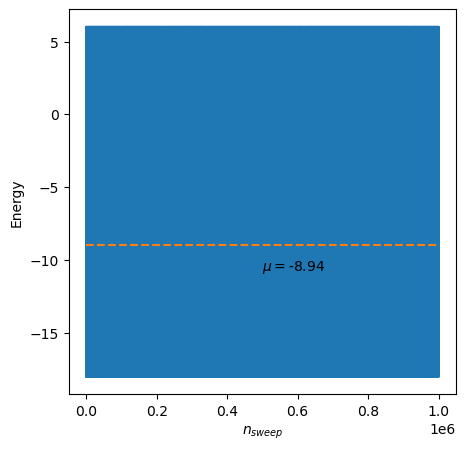

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(energies9)
ax.set_xlabel(r"$n_{sweep}$")
ax.set_ylabel("Energy")
ax.hlines(energies9.mean(), 0, window9, linestyle="dashed", color="tab:orange")
ax.annotate(
    r"$\mu =$" + str(energies9.mean().round(2)),
    xy=(window9 // 2, 1.2 * energies9.mean()),
)
plt.show()

## Theoretical Vs Empritcal 9 spin energy distribution

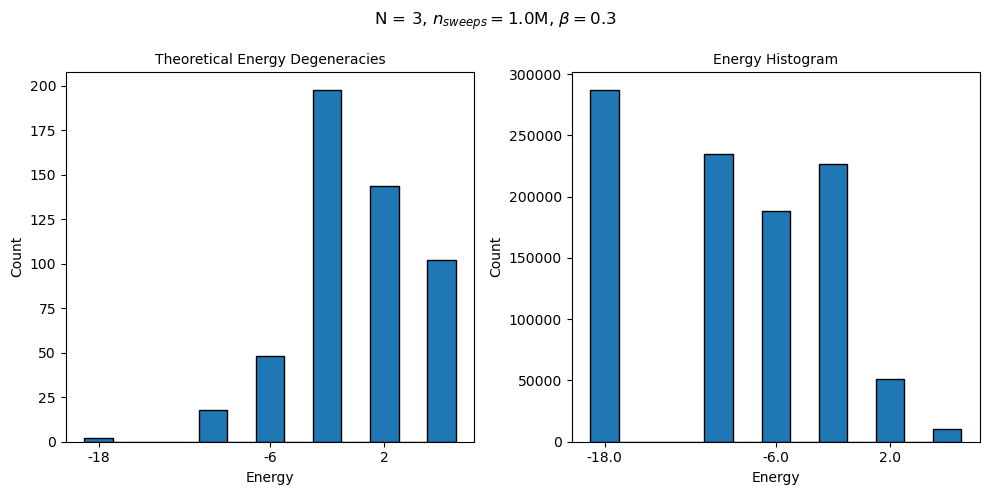

In [32]:
configs = getConfigs(N)
theoreticalEnergies = getEnergies(configs)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
energyHistogram(theoreticalEnergies, axs[0], fontsize=10)
energyHistogram(energies9, axs[1], fontsize=10)

axs[0].set_title(f"Theoretical Energy Degeneracies", fontsize=10)

axs[1].set_title(
    f"Energy Histogram",
    fontsize=10,
)

fig.suptitle(
    f"N = {N}, "
    + r"$n_{sweeps} =$"
    + f"{maxsweeps9 / int(1e6):.2}M, "
    + r"$\beta =$"
    + f"{beta9:.1}",
    fontsize=12,
)
fig.tight_layout()
plt.show()

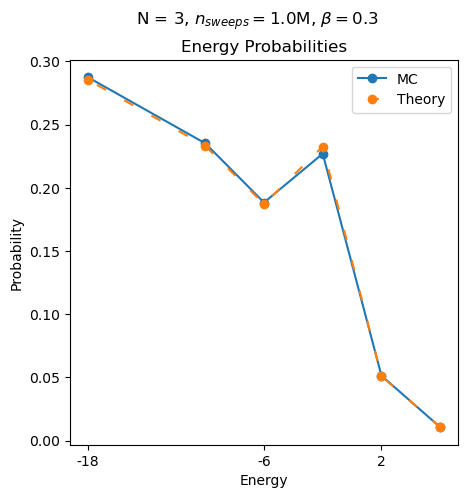

In [33]:
fig, axs = plt.subplots(figsize=(5, 5))
plotEnergyDistribution(energies9, axs)
plotTheoreticalEnergyDistribution(beta9, N, axs)
theory_configs = getConfigs(N)
energies_theory = getEnergies(theory_configs)
unique_energies_theory, counts_theory = np.unique(energies_theory, return_counts=True)

axs.set(xlabel="Energy")
axs.set_ylabel("Probability")
axs.set_title("Energy Probabilities")
axs.legend(["MC", "Theory"])
fig.suptitle(
    f"N = {N}, "
    + r"$n_{sweeps} =$"
    + f"{maxsweeps9 / int(1e6):.2}M, "
    + r"$\beta =$"
    + f"{beta9:.1}",
    fontsize=12,
)
plt.show()

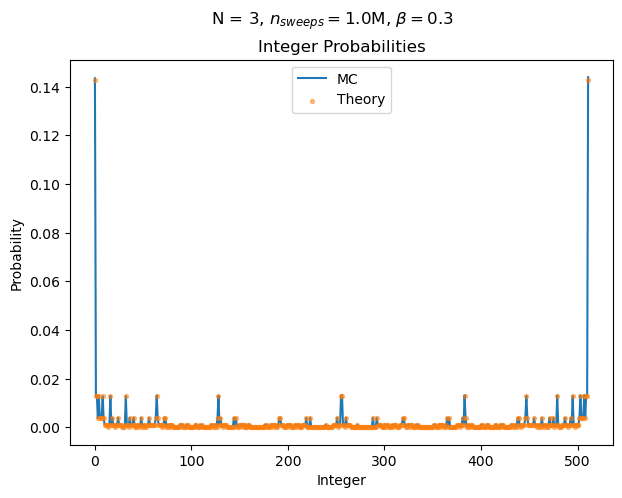

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(unique_ints, probs_ints, label="MC")
theoretical_ints, theoretical_probs = theoreticalIntDistribution(beta9, N)
ax.scatter(
    theoretical_ints,
    theoretical_probs,
    s=8,
    alpha=0.5,
    label="Theory",
    zorder=10,
    color="tab:orange",
)

ax.set(xlabel="Integer")
ax.set_ylabel("Probability")
ax.set_title("Integer Probabilities")
fig.suptitle(
    f"N = {N}, "
    + r"$n_{sweeps} =$"
    + f"{maxsweeps9 / int(1e6):.2}M, "
    + r"$\beta =$"
    + f"{beta9:.1}",
    fontsize=12,
)
ax.legend()
plt.show()

## Measuring $81^{2}$ spins

In [35]:
N = 81
betas = np.linspace(0, 1, 11)
betas = np.append(betas, 1e100)
betas = np.round(betas, 2)
nbetas = betas.shape[0]
beta_labels = betas.astype(str)
beta_labels[-1] = r"$\infty$"
loose_dash = (10, (5, 10))

In [36]:
(lattices_beta, energies_beta, mags_beta, nsweeps, totalsweeps_beta) = loadData(
    N, states_path=states_path
)

In [37]:
(expected_mags, error_mags, tcutoff_mags, unique_mags, prob_mags) = getMagExpectation(
    N, mags_beta
)

(
    expected_energies,
    error_energies,
    tcutoff_energies,
    unique_energies,
    prob_energies,
) = getEnergyExpectation(energies_beta)

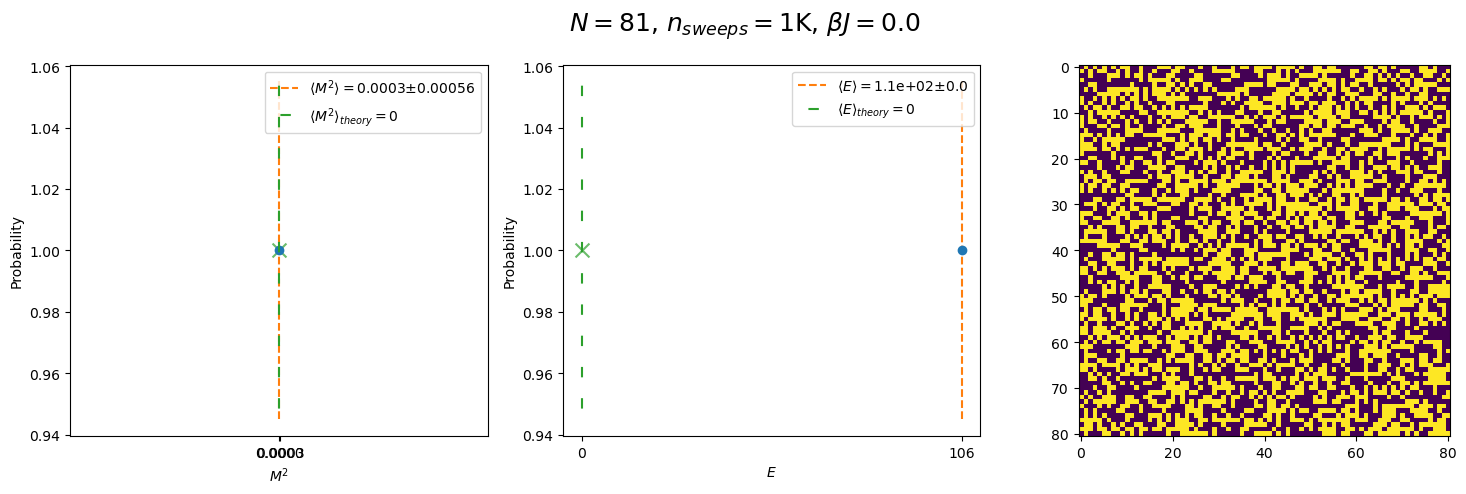

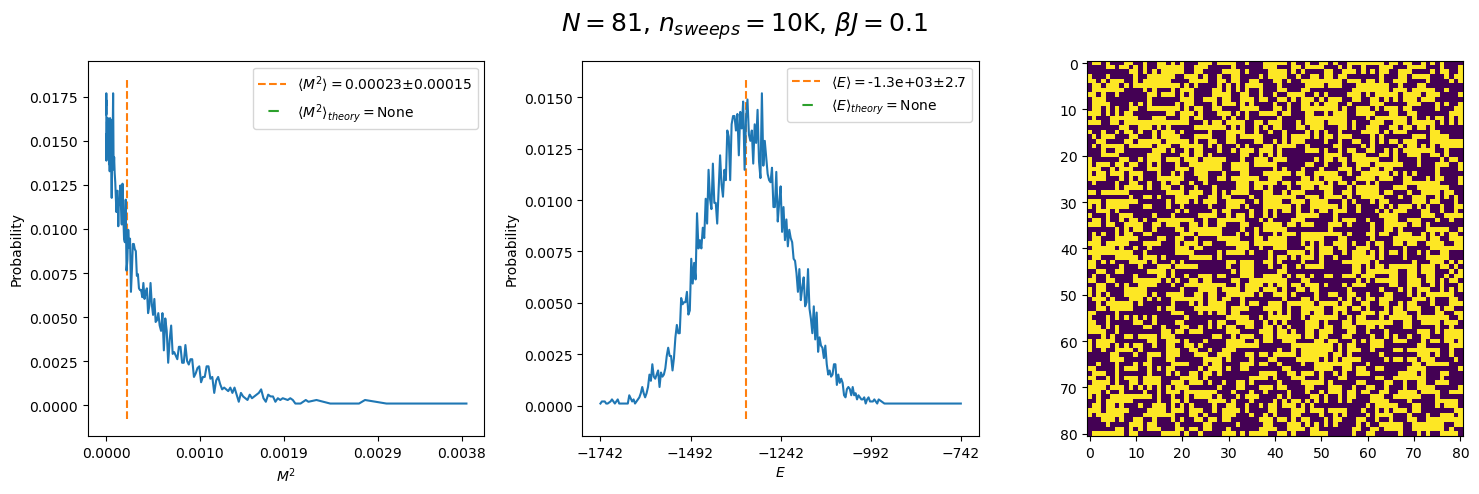

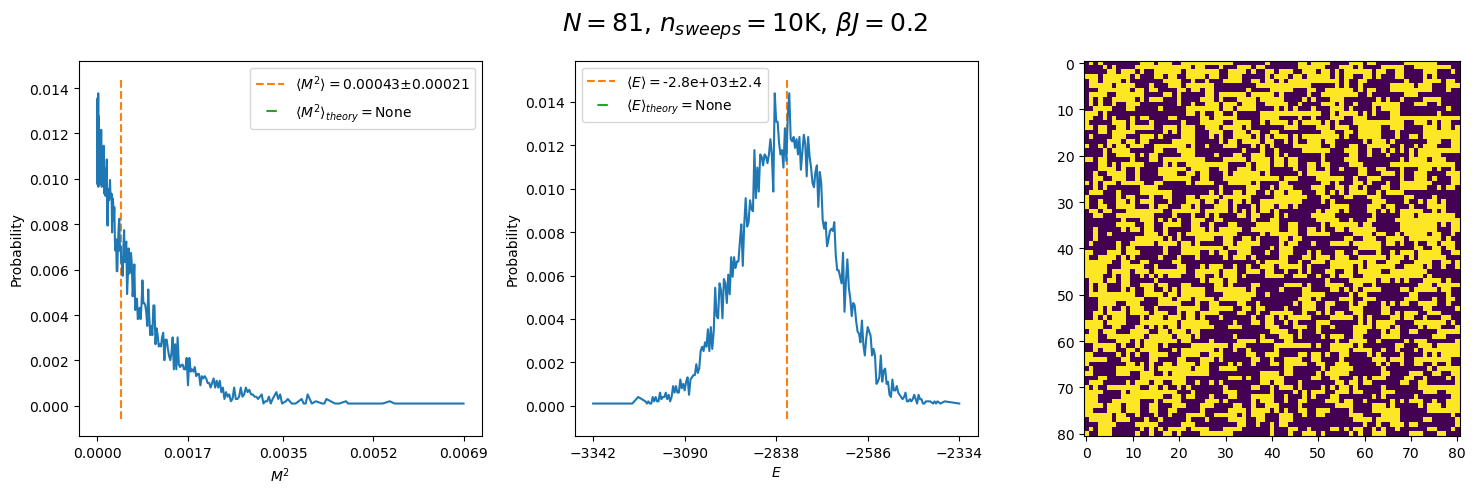

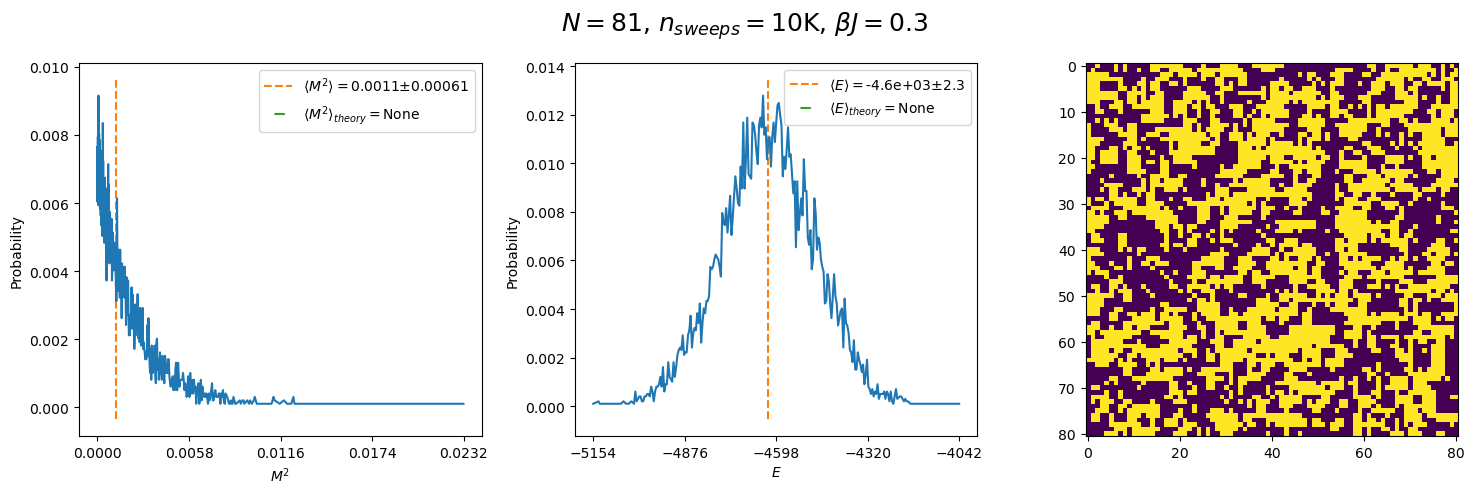

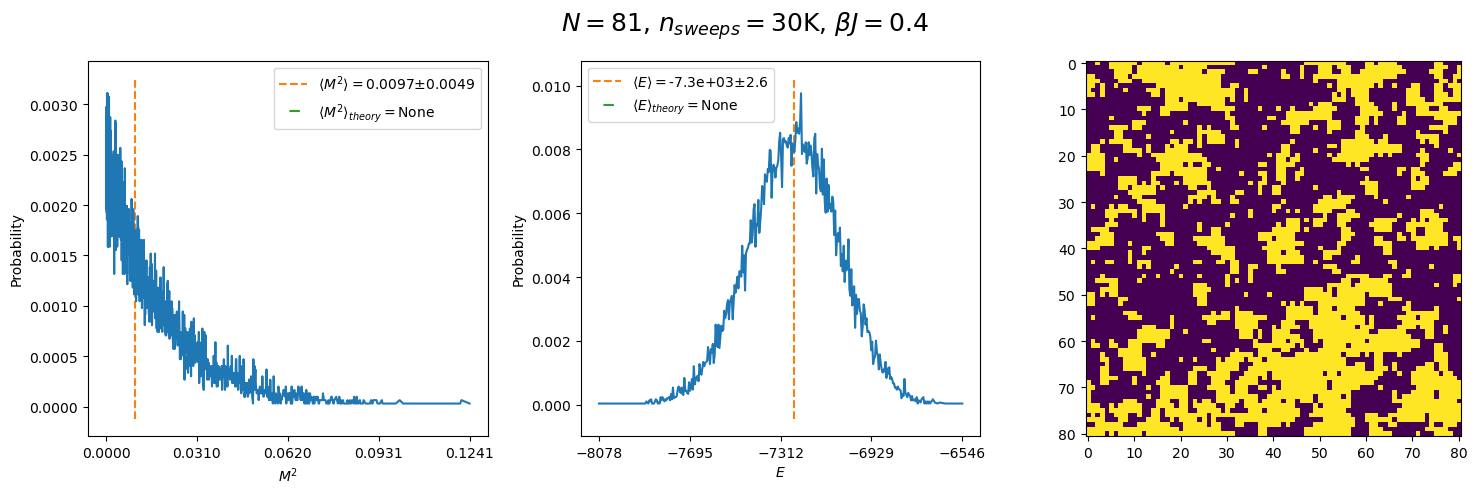

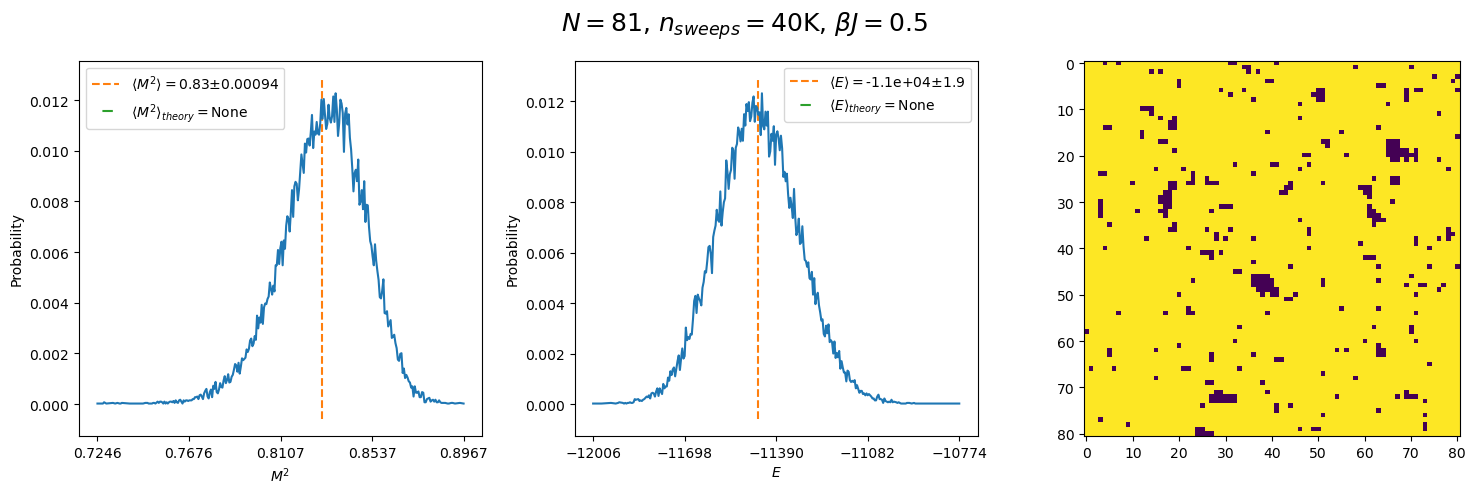

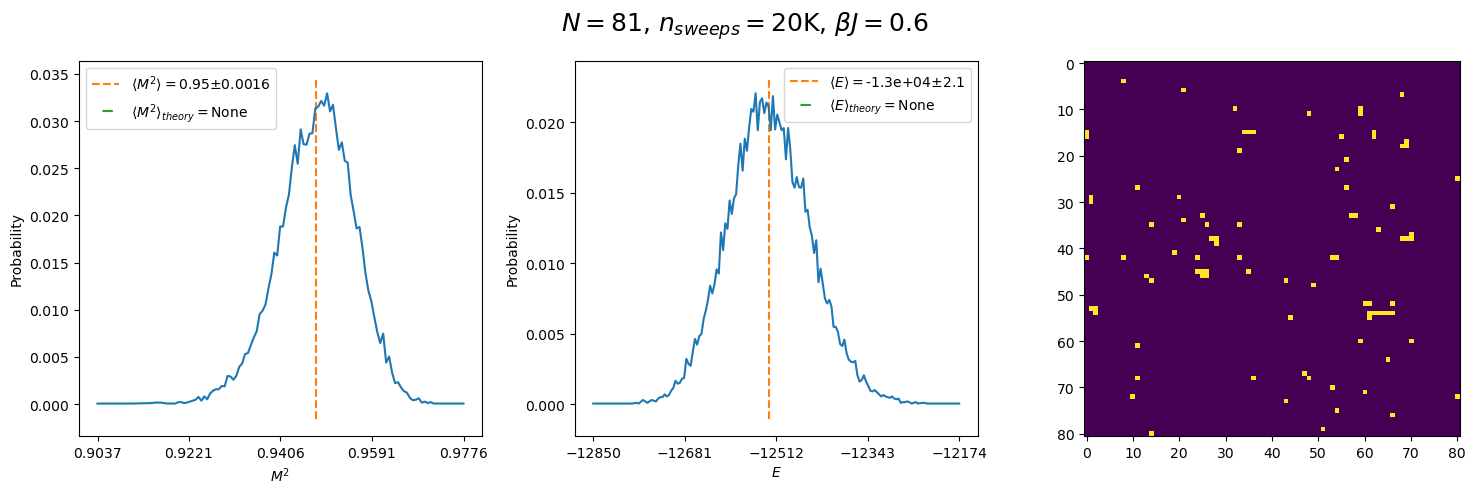

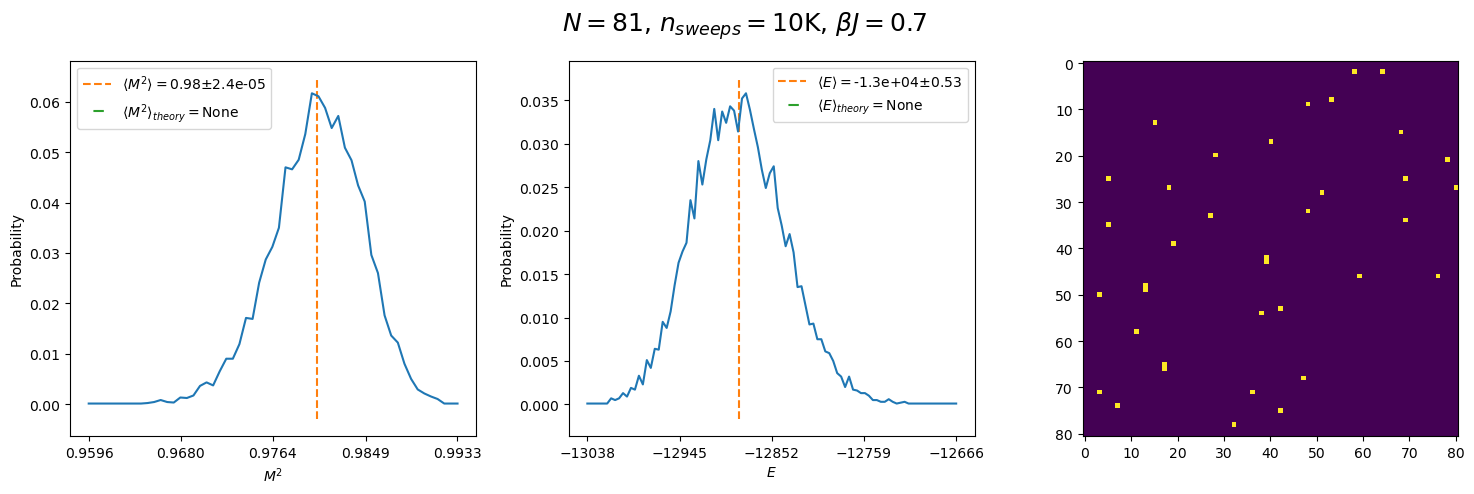

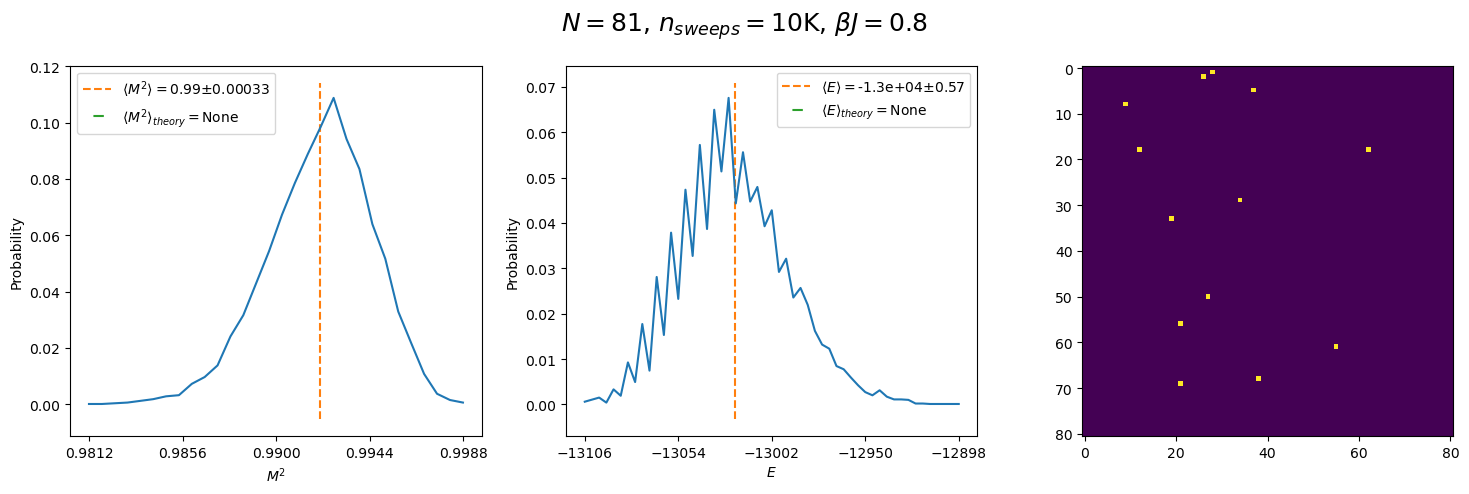

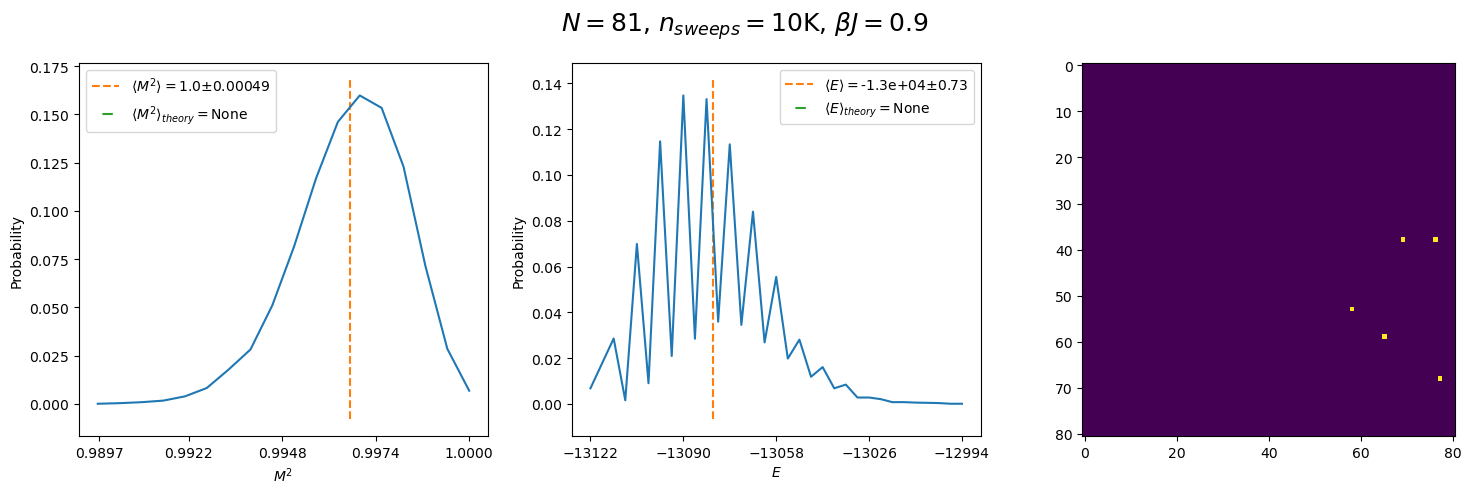

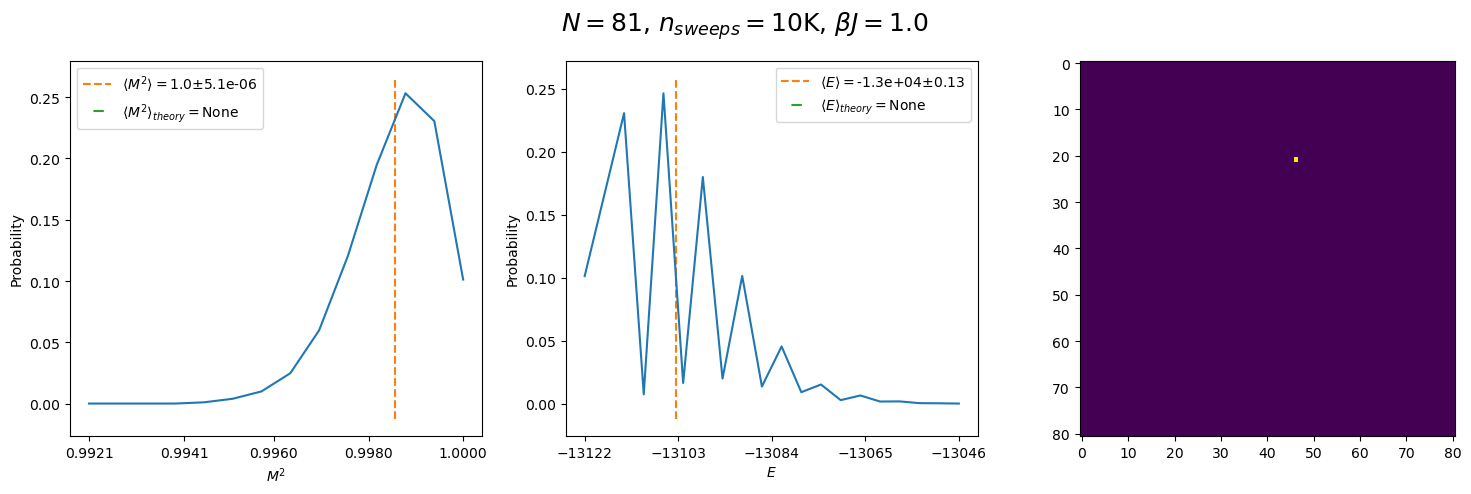

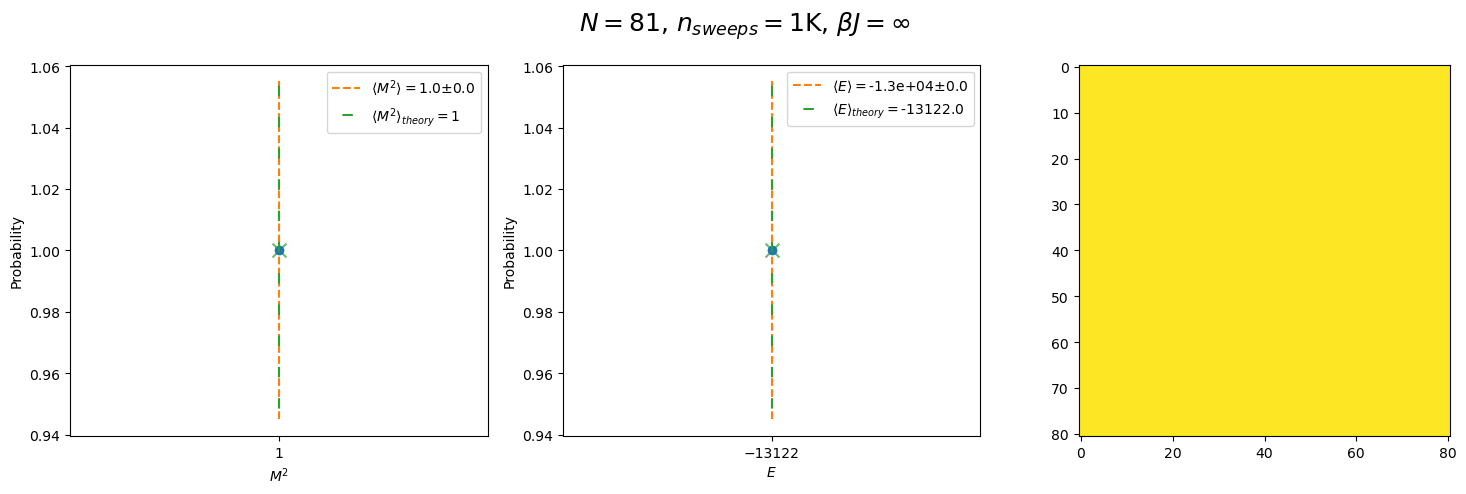

In [38]:
M0_theory = 0
Minf_theory = 1
E0_theory = 0
Einf_theory = totalEnergy(np.ones((N, N)))

for i in range(nbetas):
    beta = betas[i]

    ######### MAGNETIZATION #########

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    x = unique_mags[i].copy()
    argsort = np.argsort(x)
    x = x[argsort]
    y = prob_mags[i].copy()
    y = y[argsort]
    expected_mag = expected_mags[i]

    marker = ""
    if x.shape[0] > 1:
        xticks = np.linspace(x.min(), x.max(), 5)

    else:
        marker = "o"
        xticks = x

    M_theory = None
    if i == 0:
        if M0_theory not in xticks:
            xticks = np.insert(xticks, 0, M0_theory)
        M_theory = M0_theory
        x = np.round(x, 2)
        expected_mag = np.round(expected_mags[i], 2)

    elif i == nbetas - 1:
        if Minf_theory not in xticks:
            xticks = np.append(xticks, Minf_theory)
        M_theory = Minf_theory

    ax[0].plot(x, y, marker, zorder=3)
    ylims = ax[0].get_ylim()

    ax[0].vlines(
        expected_mag,
        ylims[0],
        ylims[1],
        linestyle="dashed",
        color="tab:orange",
        label=r"$\langle M^{2} \rangle =$"
        + f"{expected_mags[i]:.2}"
        + r"$\pm$"
        + f"{error_mags[i]:.2}",
    )

    ax[0].vlines(
        M_theory,
        ylims[0],
        ylims[1],
        linestyle=loose_dash,
        color="tab:green",
        label=r"$\langle M^{2} \rangle_{theory} =$" + f"{M_theory}",
        zorder=10,
    )

    ax[0].scatter(M_theory, 1, color="tab:green", marker="x", s=100, alpha=0.7)
    xticks = np.round(xticks, 4)
    ax[0].set_xticks(xticks)
    ax[0].legend()
    ax[0].set_xlabel(r"$M^{2}$")
    ax[0].set_ylabel("Probability")

    ######### ENERGY #########

    x = unique_energies[i].copy()
    argsort = np.argsort(x)
    x = x[argsort]
    y = prob_energies[i].copy()
    y = y[argsort]
    expected_energy = expected_energies[i]

    marker = ""
    if x.shape[0] > 1:
        xticks = np.linspace(x.min(), x.max(), 5)

    else:
        marker = "o"
        xticks = x

    E_theory = None
    if i == 0:
        if E0_theory not in xticks:
            xticks = np.insert(xticks, 0, E0_theory)
        E_theory = E0_theory
        x = np.round(x, 2)
        expected_energy = np.round(expected_energies[i], 2)

    elif i == nbetas - 1:
        if Einf_theory not in xticks:
            xticks = np.append(xticks, Einf_theory)
        E_theory = Einf_theory

    ax[1].plot(x, y, marker, zorder=3)
    ylims = ax[1].get_ylim()

    ax[1].vlines(
        expected_energy,
        ylims[0],
        ylims[1],
        linestyle="dashed",
        color="tab:orange",
        label=r"$\langle E \rangle =$"
        + f"{expected_energies[i]:.2}"
        + r"$\pm$"
        + f"{error_energies[i]:.2}",
    )

    ax[1].vlines(
        E_theory,
        ylims[0],
        ylims[1],
        linestyle=loose_dash,
        color="tab:green",
        label=r"$\langle E \rangle_{theory} =$" + f"{E_theory}",
        zorder=10,
    )

    ax[1].scatter(E_theory, 1, color="tab:green", marker="x", s=100, alpha=0.7)
    xticks = np.round(xticks, 4)
    ax[1].set_xticks(xticks)
    ax[1].legend()
    ax[1].set_xlabel(r"$E$")
    ax[1].set_ylabel("Probability")

    ax[2].imshow(lattices_beta[i][-1], vmin=-1, vmax=1)

    title = (
        r"$N =$"
        + f"{N}, "
        + r"$n_{sweeps} = $"
        + f"{int(round(nsweeps[i], -3) / 1e3)}K, "
        + r"$\beta J =$"
        + f"{beta_labels[i]:1}"
    )

    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    plt.show()

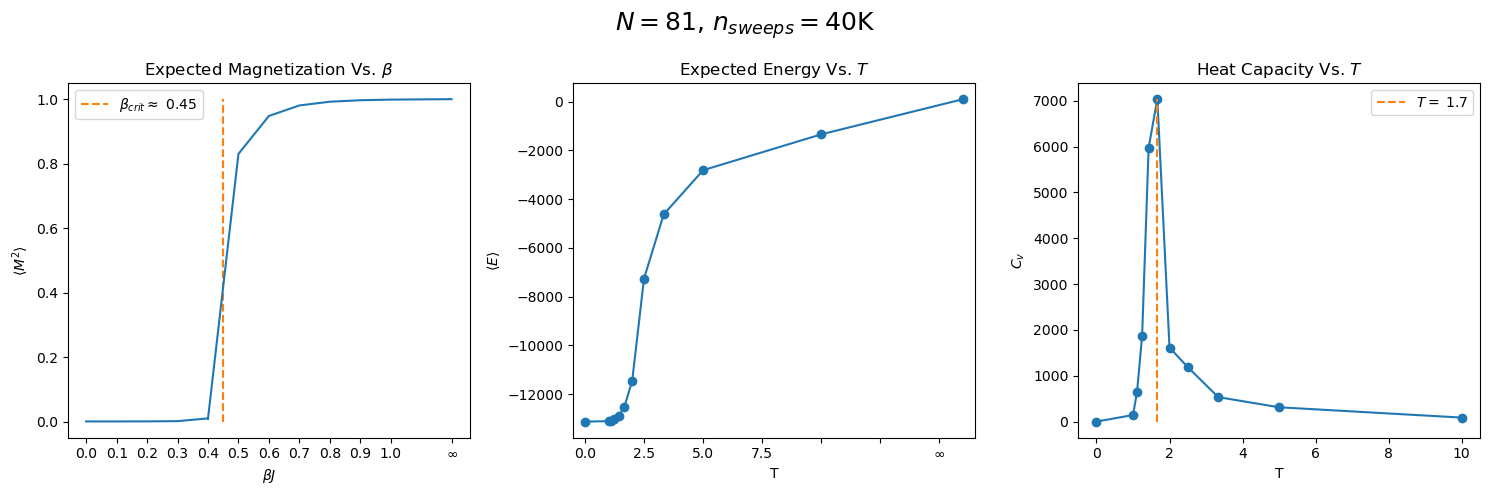

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

######### MAGNETIZATION #########

dMs = [expected_mags[i + 1] - expected_mags[i] for i in range(nbetas - 1)]
dMs = np.array(dMs)
argmax = dMs.argmax()
beta_approx = (betas[argmax] + betas[argmax + 1]) / 2
x = betas.copy()
x[-1] = 1.2

ax[0].vlines(
    beta_approx,
    0,
    1.0,
    color="tab:orange",
    linestyle="dashed",
    label=r"$\beta_{crit} \approx $ " + f"{beta_approx}",
)

ax[0].errorbar(x, expected_mags, yerr=error_mags)
ax[0].set_xticks(x, beta_labels)
ax[0].set_xlabel(r"$\beta J$")
ax[0].set_ylabel(r"$\langle M^{2} \rangle$")
ax[0].legend()
ax[0].set_title(r"Expected Magnetization Vs. $\beta$")


######### ENERGY #########

Ts = 1 / (betas[1:])
Ts = np.insert(Ts, 0, 16)
argsort = np.argsort(Ts)
Ts = Ts[argsort]
Es = expected_energies[argsort]

ax[1].plot(Ts, Es, marker="o")
ax[1].set_xlabel("T")
ax[1].set_ylabel(r"$\langle E \rangle$")

xticks = ax[1].get_xticks()
labels = xticks.astype(str)
labels[-2] = r"$\infty$"
labels[-3] = ""
labels[-4] = ""
ax[1].set_xticks(xticks, labels)
ax[1].set_xlim(-0.5, 16.5)
ax[1].set_title(r"Expected Energy Vs. $T$")


######### HEAT CAPACITY #########

spline = scipy.interpolate.UnivariateSpline(betas[:-1], expected_energies[:-1], k=2)
dEdT = spline.derivative()
dBdT = -betas[:-1] ** 2
Cv = dEdT(betas[:-1]) * dBdT

ax[2].plot(Ts[:-1], Cv, marker="o")
ax[2].set_xlabel("T")
ax[2].set_ylabel(r"$C_{v}$")
argmax = np.argmax(Cv)
ax[2].vlines(
    Ts[argmax],
    Cv.min(),
    Cv.max(),
    label=r"$T =$ " + f"{Ts[argmax]:.2}",
    color="tab:orange",
    linestyle="dashed",
)
ax[2].legend()
ax[2].set_title(r"Heat Capacity Vs. $T$")

fig.suptitle(
    r"$N =$" + f"{N}, " + r"$n_{sweeps} = $" f"{int(round(nsweeps.max(), -3) / 1e3)}K",
    fontsize=18,
)

fig.tight_layout()
plt.show()

## Renormalization Group

In [40]:
@numba.njit(nogil=True, fastmath=True)
def coarse27(nbetas, nsweeps, lattices81):
    lattices81 = lattices81.copy()
    lattices27_coarse = np.zeros((nbetas, nsweeps.max(), 27, 27))
    mags27_coarse = np.zeros((nbetas, nsweeps.max()))

    for bi in range(nbetas):
        for sweep in range(nsweeps[bi]):
            lattice81 = lattices81[bi, sweep, :, :]
            lattice27 = lattices27_coarse[bi, sweep, :, :]

            for i in range(27):
                for j in range(27):
                    sub_arr = lattice81[3 * i : 3 * (i + 1), 3 * j : 3 * (j + 1)]

                    if np.mean(sub_arr) < 0:
                        lattice27[i, j] = -1

                    else:
                        lattice27[i, j] = 1

            mags27_coarse[bi, sweep] = np.sum(lattice27)

    return lattices27_coarse, mags27_coarse


@numba.njit(nogil=True, fastmath=True)
def coarse9(nbetas, nsweeps, lattices27):
    lattices27 = lattices27.copy()
    lattices9_coarse = np.zeros((nbetas, nsweeps.max(), 9, 9))
    mags9_coarse = np.zeros((nbetas, nsweeps.max()))

    for bi in range(nbetas):
        for sweep in range(nsweeps[bi]):
            lattice27 = lattices27[bi, sweep, :, :]
            lattice9 = lattices9_coarse[bi, sweep, :, :]

            for i in range(9):
                for j in range(9):
                    sub_arr = lattice27[3 * i : 3 * (i + 1), 3 * j : 3 * (j + 1)]

                    if np.mean(sub_arr) < 0:
                        lattice9[i, j] = -1

                    else:
                        lattice9[i, j] = 1

            mags9_coarse[bi, sweep] = np.sum(lattice9)

    return lattices9_coarse, mags9_coarse

In [41]:
N = 27
(
    lattices27_beta,
    energies27_beta,
    mags27_beta,
    nsweeps27,
    totalsweeps27_beta,
) = loadData(N, states_path=states_path)

lattices27_coarse, mags27_coarse = loadCoarseData(
    N, lattices_beta, nsweeps, states_path=states_path
)
lattices9_coarse, mags9_coarse = loadCoarseData(
    9, lattices27_beta, nsweeps27, states_path=states_path
)

In [42]:
(
    expected_mags27,
    error_mags27,
    tcutoff_mags27,
    unique_mags27,
    prob_mags27,
) = getMagExpectation(N, mags27_beta)

(
    expected_mags27_coarse,
    error_mags27_coarse,
    tcutoff_mags27_coarse,
    unique_mags27_coarse,
    prob_mags27_coarse,
) = getMagExpectation(27, mags27_coarse)


expected_mags27_coarse[0] = 0
expected_mags27[0] = 0

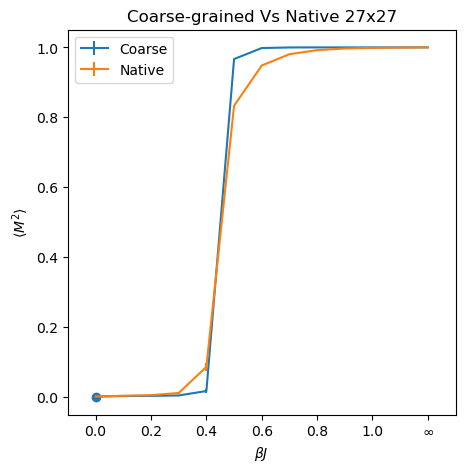

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))

x = betas.copy()
y = expected_mags27_coarse.copy()
x[-1] = 1.2
ax.errorbar(x, y, yerr=error_mags27_coarse, label="Coarse")
ax.set_xlabel(r"$\beta J$")
ax.set_ylabel(r"$\langle M^{2} \rangle$")
ax.set_title("Coarse-grained Vs Native 27x27")
xticks = np.round(ax.get_xticks(), 1)
labels = xticks.astype(str)
labels[-2] = beta_labels[-1]
ax.scatter(0, 0)
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.1, 1.3)
y = expected_mags27.copy()
ax.errorbar(x, y, yerr=error_mags27, label="Native")
ax.legend()


plt.show()

## RJ

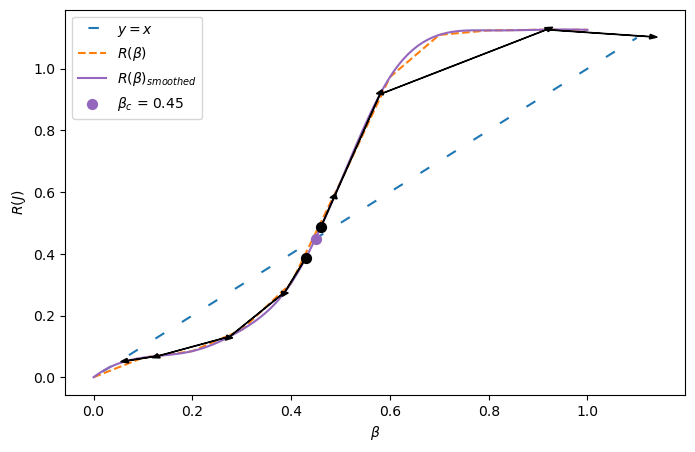

In [44]:
n = nbetas - 1
slice = np.arange(n)
B = scipy.interpolate.CubicSpline(expected_mags27[slice], betas[slice])
R = np.zeros(n)
for i, M in enumerate(expected_mags27_coarse[slice]):
    R[i] = B(M)

new_betas = np.linspace(0, 1, 100)
new_R = B(new_betas)
Rsavgol = scipy.signal.savgol_filter(R, 5, 2)
Rsmooth = scipy.interpolate.CubicSpline(betas[slice], R)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    np.linspace(0, 1.1, 100),
    np.linspace(0, 1.1, 100),
    label=r"$y=x$",
    linestyle=loose_dash,
)

B0s = [0.43, 0.46]
for B0 in B0s:
    ax.scatter(B0, Rsmooth(B0), color="black", s=50, zorder=100)

    Bcurr = B0
    for i in range(4):
        dx = Rsmooth(Bcurr) - Bcurr
        dy = Rsmooth(Rsmooth(Bcurr)) - Rsmooth(Bcurr)
        x = Bcurr
        y = Rsmooth(Bcurr)
        ax.arrow(
            x,
            y,
            dx,
            dy,
            head_width=0.015,
            head_length=0.015,
            fc="black",
            ec="black",
            zorder=200,
        )
        Bcurr = Rsmooth(Bcurr)


ax.plot(betas[slice], R, color="tab:orange", label=r"$R(\beta)$", linestyle="dashed")
ax.plot(
    new_betas,
    Rsmooth(new_betas),
    color="tab:purple",
    label=r"$R(\beta)" r"_{smoothed}$",
    zorder=10,
)

criticalPoint = scipy.optimize.fsolve(lambda x: Rsmooth(x) - x, 0.5)
ax.scatter(
    criticalPoint,
    Rsmooth(criticalPoint),
    color="tab:purple",
    s=50,
    zorder=100,
    label=r"$\beta_{c}$" + f" = {criticalPoint[0]:.2}",
)

ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$R(J)$")
ax.legend()
plt.show()

In [45]:
slope = Rsmooth.derivative()(criticalPoint)[0]
b = 3
v = np.round(np.log(b) / np.log(slope), 2)
print("critical exponent:", v)

critical exponent: 0.91
